In [1]:
import wandb

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym

import os
import sys
sys.path.append('../src/')
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
from torch.nn import functional as F

%reload_ext autoreload
%autoreload 2

In [2]:
def get_distance_matrix(X,Y):
  """"""
  return cdist(X,Y,metric='euclidean')

def get_distance(point1,point2):
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)


# Import internal modules

In [3]:
sys.path.append('../src')
from environments import ToyEnv_v2
from offline_dataset import ToyOfflineDatasetv2
from test_utils import seed_everything
from algorithms import DDQN
from agents import Agent

# Data simulation functions

In [6]:
def get_closest_dist_ordering(coords, distance_matrix):
    """
    Given a list of coordinates, picks the field closest to the origin first, then 
    always picks the field closest unless it has already been visited
    """
    # matrix where each row corresponds to ordered indices of which is furthest
    ordered_mat_indices = np.argsort(distance_matrix, axis=1) # low to high

    # get index closest to origin
    last_ind = 0
    target_indices = [last_ind]
    row_index = last_ind
    for _ in range(len(coords) - 1):
        col_index = 0 # index of col of matrix

       # if this index has already been chosen, 
        current_ind = ordered_mat_indices[row_index][col_index]
        while current_ind in target_indices:
            col_index += 1
            current_ind = ordered_mat_indices[row_index][col_index]
        target_indices.append(current_ind)
        row_index = current_ind
    return target_indices

def reward_function(target_coords):
    coords = target_coords[:, :-1, :]
    last_coords = target_coords[:, 1:, :]
    
    separation = np.linalg.norm(coords - last_coords, axis=2)
    mean_sep, std_sep = np.mean(separation), np.std(separation)
    
    low_sep_lim = mean_sep - .5 * std_sep
    mid_sep_lim = mean_sep + .5 * std_sep
    max_sep_lim = mean_sep + 1.5 * std_sep
    max_reward_mask = separation < low_sep_lim
    mid_reward_mask = np.logical_and(separation < mid_sep_lim, separation >= low_sep_lim)
    low_reward_mask = np.logical_and(separation <= max_sep_lim, separation >= mid_sep_lim)
    reward_shape = (len(target_coords), len(target_coords[0]) - 1)

    rewards = np.zeros(shape=reward_shape, dtype=np.float32)
    rewards[low_reward_mask] = .1
    rewards[mid_reward_mask] = .5
    rewards[max_reward_mask] = 1
    
    return rewards, separation

def get_nvisits(target_field_ids, nfields):
    # start with 0 visits
    train_size = len(target_field_ids)
    nvisits_base = np.zeros(shape=(nfields), dtype=np.int32)
    full_nvisits = np.zeros(shape=(train_size, len(target_field_ids[0]) - 1, nfields), dtype=np.int32)

    # for each night and each field in night, add 1 count to field then copy new nvisits base into full_nvisits[night,obs]
    for i, night_obs in enumerate(target_field_ids):
        for j, field_id in enumerate(night_obs[1:]):
            nvisits_base[field_id] += 1
            full_nvisits[i, j] = nvisits_base.copy()
        # print(np.argwhere(nvisits_base))
    return full_nvisits
def generate_dataset(n_datasets=100, n_unique=10, n_obs_per_night=10):
    """
    Generates the following dataset
        (1) a random sample of points on a 20x20 integer grid for x number of nights with a static number of observations per night.
        (2) Each night the first observation is always the one that is closest to zenith, and always chooses the next point to be the one that is closest.
        (3) The set of quantities needed to perform training
    
    Returns
    -------
    
    """
    grid_max = 5
    ra_range = (-grid_max, grid_max)
    dec_range = (-grid_max, grid_max)
    # set number of unique fields
    max_visits = int(n_datasets * n_obs_per_night / n_unique)

    # generate random coords
    ra_list = np.random.randint(ra_range[0], ra_range[1], size=(n_unique), dtype=np.int32)
    dec_list = np.random.randint(dec_range[0], dec_range[1], size=(n_unique), dtype=np.int32)
    unique_coords = np.stack([ra_list, dec_list], axis=1) # shape (num_ep, nra_points, ndec_points)
    unique_field_ids = np.arange(len(unique_coords), dtype=np.int32)
    field_coord_mapping = {id: c for id, c in zip(unique_field_ids, unique_coords)}
    field_coord_mapping.update({-1: np.array([0,0])})

    # repeat coords for full dataset
    coords = np.repeat(unique_coords, max_visits, axis=0)
    field_ids = np.repeat(unique_field_ids, max_visits)
    
    # randomize order
    new_indices = list(range(len(coords)))
    random.shuffle(new_indices)
    coords = coords[new_indices]
    field_ids = field_ids[new_indices]
    coords = coords.reshape((n_datasets, n_obs_per_night, 2))
    field_ids = field_ids.reshape((n_datasets, n_obs_per_night))
     
    # include "-1" fields ie (0,0)
    zeros = np.zeros(shape=(n_datasets, 2), dtype=np.int32)
    coords = np.concatenate((zeros[:, np.newaxis, :], coords), axis=1)
    field_ids = np.concatenate( (np.full(n_datasets, fill_value=-1)[:, np.newaxis], field_ids), axis=1)

    distance_matrices = np.empty(shape=(n_datasets, n_obs_per_night+1, n_obs_per_night+1), dtype=np.float32)
    full_target_fields = []
    full_target_coords = []

    for i in range(n_datasets):
        distance_matrices[i] = get_distance_matrix(coords[i], coords[i])
        np.fill_diagonal(distance_matrices[i], np.inf)
        target_indices = get_closest_dist_ordering(coords[i], distance_matrices[i])
        full_target_fields.append(field_ids[i][target_indices])
        full_target_coords.append(coords[i][target_indices])

    full_target_fields = np.array(full_target_fields, dtype=np.int32)
    full_target_coords = np.array(full_target_coords, dtype=np.int32)
    nfields =  np.int32(len(np.unique(full_target_fields)) - 1)
    #max_visits =  #np.int32(len(full_target_fields) // nfields * (len(full_target_fields[0]) - 1))
    full_nvisits = get_nvisits(full_target_fields, nfields)
    # full_stepnum = np.array([np.arange(0, 10, dtype=np.int32) for i in range(len(full_target_fields))], dtype=np.int32)
    
    # obs: stepnum, target_coords, target_field_ids, nvisits
    # full_obs = (full_target_fields[:, :-1]) #full_target_coords[:, :-1], full_stepnum[:, :-1], , full_nvisits[:, :-1])
    # full_next_obs = (full_target_fields[:, 1:]) #full_target_coords[:, 1:], full_stepnum[:, 1:], , full_nvisits[:, 1:])
    full_actions = full_target_fields[:, 1:]
    full_rewards, full_separations = reward_function(full_target_coords)
    full_dones = np.zeros_like(full_target_fields[:, 1:], dtype=bool)
    full_dones[:, -1] = True
    full_action_masks = full_nvisits != max_visits
    # full_action_mask = action_masks[:, :-1]
    # full_next_action_mask = action_masks[:, 1:]
    obs = np.concatenate((full_target_fields[:, :-1, np.newaxis], full_target_coords[:, :-1]), axis=2)
    next_obs = np.concatenate((full_target_fields[:, 1:, np.newaxis], full_target_coords[:, 1:]), axis=2)

    return obs, full_actions, full_rewards, next_obs, full_dones, full_action_masks, nfields, max_visits, full_separations, field_coord_mapping

# Experiment configurations and data simulation

In [7]:
SEED = 10
env_name = 'ToyEnv_v2'
train_size = 1

seed_everything(SEED)
dataset = ToyOfflineDatasetv2(generate_dataset, train_size)

OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)


## Visualize data

In [9]:
plt.hist(full_separations.flatten())

NameError: name 'full_separations' is not defined

In [10]:
c = plt.imshow(full_separations, aspect='auto')
plt.colorbar(c)
plt.title('Separations')

NameError: name 'full_separations' is not defined

In [11]:
plt.hist(full_rewards.flatten())

NameError: name 'full_rewards' is not defined

In [12]:

c = plt.imshow(full_rewards, aspect='auto')

NameError: name 'full_rewards' is not defined

In [13]:
full_target_coords = obs[:, :, 1:]
full_target_fields = obs[:, :, 0]

NameError: name 'obs' is not defined

NameError: name 'full_target_coords' is not defined

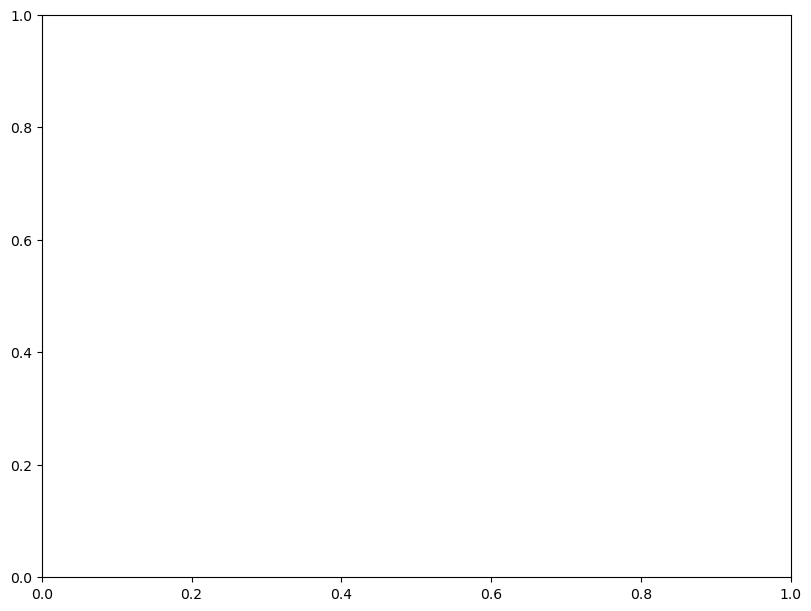

In [14]:
j = np.random.randint(train_size)

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(full_target_coords[j][:, 0], full_target_coords[j][:, 1], linestyle='dotted', label='target sequence', zorder=1, color='grey')

for i, index in enumerate(full_target_fields[j]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
    elif i == len(full_target_fields[j])-1:
        print(i)
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 30
        label=None
    ax.scatter(full_target_coords[j][i][0], full_target_coords[j][i][1], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()
ax.set_title(f'Dataset {j}');

# Configure and instantiate env, dataset, algorithm, and agent

In [15]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v2,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)
env = gym.make(f"gymnasium_env/{env_name}", dataset=dataset)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)


In [16]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


In [18]:
alg_config = {
    'obs_dim': dataset._obs_dim,
    'action_dim': dataset._action_dim,
    'hidden_dim': 128,
    'gamma': .99,
    'tau': .001,
    'device': device,
    'lr': 1e-5,
    'loss_fxn': F.huber_loss,
    'use_dqn': False
}
alg = DDQN(**alg_config)

TypeError: AdamW.__init__() got an unexpected keyword argument 'use_dqn'

In [ ]:

agent_config = {
    'algorithm': alg,
    'name': 'ddqnAgent'
    }

agent = Agent(**agent_config)

# Train

In [192]:
agent.fit(
    dataset,
    num_epochs=20000,
    batch_size=8, 
    outdir=OUTDIR
    )

	 epoch: 0
	 epoch: 1
	 epoch: 2
	 epoch: 3
	 epoch: 4
	 epoch: 5
	 epoch: 6
	 epoch: 7
	 epoch: 8
	 epoch: 9
	 epoch: 10
	 epoch: 11
	 epoch: 12
	 epoch: 13
	 epoch: 14
	 epoch: 15
	 epoch: 16
	 epoch: 17
	 epoch: 18
	 epoch: 19
	 epoch: 20
	 epoch: 21
	 epoch: 22
	 epoch: 23
	 epoch: 24
	 epoch: 25
	 epoch: 26
	 epoch: 27
	 epoch: 28
	 epoch: 29
	 epoch: 30
	 epoch: 31
	 epoch: 32
	 epoch: 33
	 epoch: 34
	 epoch: 35
	 epoch: 36
	 epoch: 37
	 epoch: 38
	 epoch: 39
	 epoch: 40
	 epoch: 41
	 epoch: 42
	 epoch: 43
	 epoch: 44
	 epoch: 45
	 epoch: 46
	 epoch: 47
	 epoch: 48
	 epoch: 49
	 epoch: 50
	 epoch: 51
	 epoch: 52
	 epoch: 53
	 epoch: 54
	 epoch: 55
	 epoch: 56
	 epoch: 57
	 epoch: 58
	 epoch: 59
	 epoch: 60
	 epoch: 61
	 epoch: 62
	 epoch: 63
	 epoch: 64
	 epoch: 65
	 epoch: 66
	 epoch: 67
	 epoch: 68
	 epoch: 69
	 epoch: 70
	 epoch: 71
	 epoch: 72
	 epoch: 73
	 epoch: 74
	 epoch: 75
	 epoch: 76
	 epoch: 77
	 epoch: 78
	 epoch: 79
	 epoch: 80
	 epoch: 81
	 epoch: 82
	 epoch: 83
	 

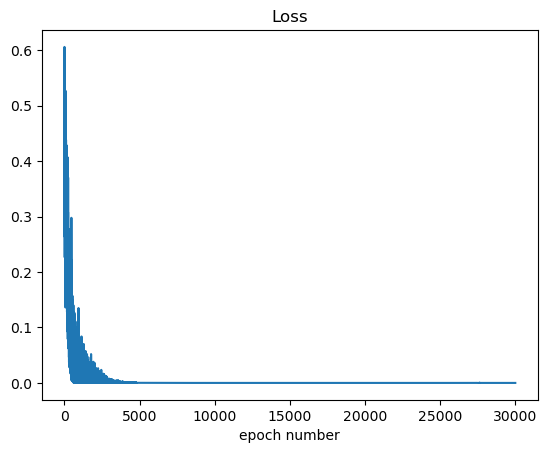

Text(0, 0.5, 'Q vlaue')

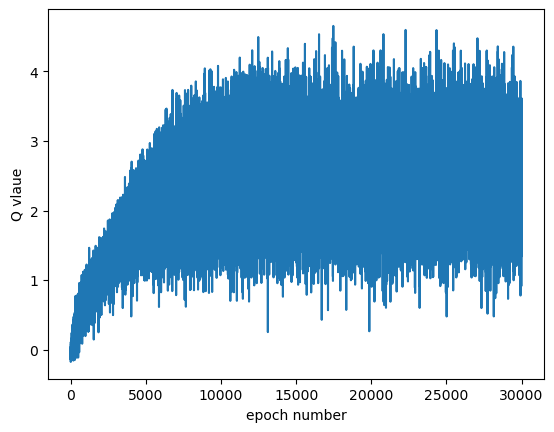

In [193]:
plt.plot(agent.loss_history)
plt.title('Loss')
plt.xlabel('epoch number')
plt.show();
plt.plot(agent.q_history)
plt.xlabel('epoch number')
plt.ylabel('Q vlaue')

# Evaluate

In [194]:
eval_metrics = agent.evaluate(env=env, num_episodes=10)

terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9


In [195]:
vars(dataset).keys()

dict_keys(['data_generator', 'train_size', 'obs', 'actions', 'rewards', 'next_obs', 'dones', 'action_masks', '_nfields', '_max_visits', '_full_separations', '_field_coord_mapping', '_obs_per_night', '_obs_dim', '_action_dim'])

In [196]:
eval_metrics.keys()

dict_keys(['mean_reward', 'std_reward', 'min_reward', 'max_reward', 'episode_rewards', 'observations', 'rewards'])

In [197]:
eval_sequence = eval_metrics['observations']['ep-0']
print(eval_sequence.shape)

(11, 3)


In [198]:
eval_metrics['rewards']

{'ep-0': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-1': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-2': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-3': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-4': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-5': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-6': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-7': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-8': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3]),
 'ep-9': array([0.4, 0.2, 0.6, 0.4, 0.6, 0.2, 0.2, 0.3, 0.1, 0.3])}

In [199]:
dataset.rewards

array([[1. , 0.5, 0.5, 1. , 1. , 0.1, 0. , 1. , 0. , 1. ]], dtype=float32)

#  Results

10


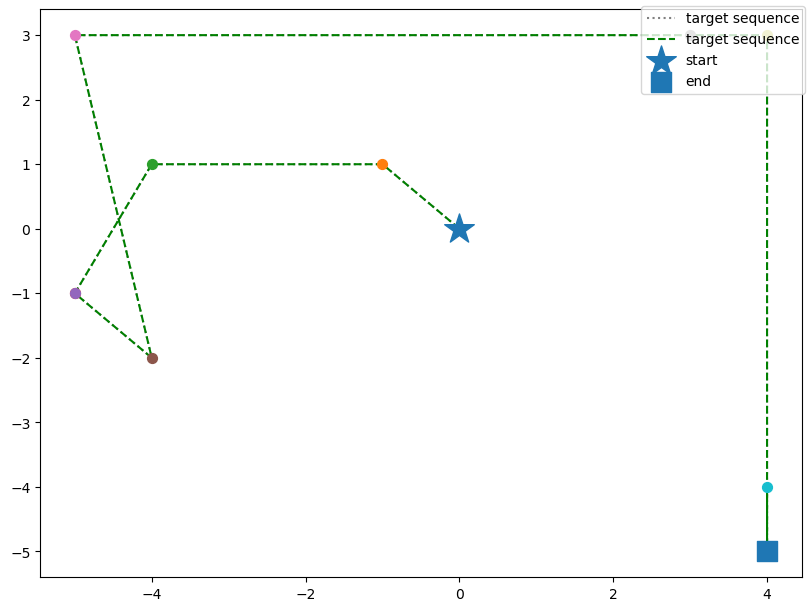

In [202]:
# j = np.random.randint(train_size)

j = 0

target_sequence = np.concatenate((dataset.obs, dataset.next_obs[:, -1][np.newaxis, :, :]), axis=1)
eval_sequence = eval_metrics['observations']['ep-0']

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(target_sequence[j][:, 1], target_sequence[j][:, 2], linestyle='dotted', label='target sequence', zorder=1, color='grey')
ax.plot(eval_sequence[:, 1], eval_sequence[:, 2], linestyle='dashed', label='target sequence', zorder=1, color='green')

for i, index in enumerate(target_sequence[j][:, 0]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
        color='black'
    elif i == len(target_sequence[j][:, 0])-1:
        print(i)
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 50
        label=None
    ax.scatter(target_sequence[j][i][1], target_sequence[j][i][2], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()

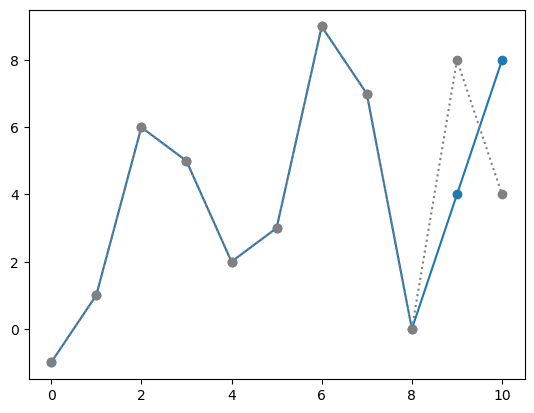

In [203]:
plt.plot(eval_sequence[:, 0], marker='o')
plt.plot(target_sequence[0, :, 0], marker='o', label=True, color='grey', linestyle='dotted')

- Normalizing rewards such that there are negative rewards hinders learning significantly. Only a few points were correct

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()

# Tune hyperparameters